In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["KERAS_BACKEND"] = "jax"
import keras

import numpy as np
import jax
from keras import ops

In [2]:
from distributions import ZeroInflatedDist, QuantizedNormal
from plotting_funcs import sample_and_plot, plot_dist, plot_hexagon_grid

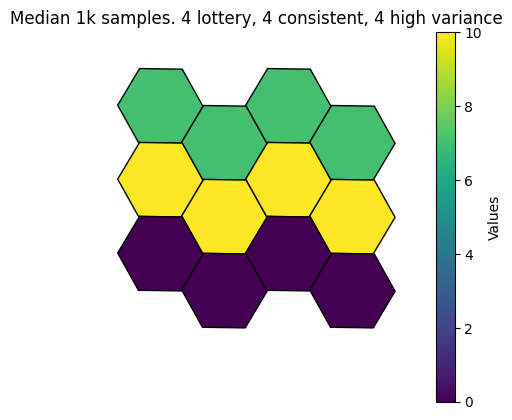

In [3]:
consistent_4 = [QuantizedNormal(7, 0.1) for _ in range(4)]

highvar_4 = [ZeroInflatedDist(QuantizedNormal(10, 0.1), 1-0.7) for _ in range(4)]

powerball_4 = [ZeroInflatedDist(QuantizedNormal(100, 0.1), 0.9) for _ in range(4)]
dist_S = consistent_4 + highvar_4 +powerball_4
S=12
sample_and_plot(dist_S, size=1000, median=True, title='Median 1k samples. 4 lottery, 4 consistent, 4 high variance')

## Problem definitions
We care about modeling an outcome across space and time. Let us define $s \in 1, \dots, S$ and $t \in 1, \dots, T$ for $S, T \in \mathbb{N}$ where $S$ is the total number of locations and $T$ is the number of timesteps.

We have some independent variables $\boldsymbol{X}$ where $\boldsymbol{x}_{s,t}$ is the vector of independent variables at location $s$ and time $t$. 

### 1. An instance is a location-time

We seek to model $\boldsymbol{y} \in \mathbb{N}^{s+t}$, where $\boldsymbol{y} = [..., y_{s,t}, ...]$ 





For simplicity, we assume locations and timepoints are independent and we can write:
$$p(\boldsymbol{y}) = \sum_{t=1}^T \sum_{s=1}^S p(y_{i,t})

### 2. An instance is a timestep
We seek to model $\boldsymbol{Y} \in \mathbb{N}^{S \times T}$ where $Y = [\dots, \boldsymbol{y}_t, \dots]$ and $\boldsymbol{y}_t = [\dots, y_{s,t}, \dots]$

We can make the same assumption as in the location-time definition, and write:
$$p(\boldsymbol{Y}) = \sum_{t=1}^T \sum_{s=1}^S p(y_{i,t})

## Model

We start with a simple GLM with Poisson likelihood. We retain our independence assumptions and write:

$\boldsymbol{Y}$ or $\boldsymbol{y}$ $\sim \text{Poisson}(\lambda)$
Here $\lambda \coloneqq \mathbb{E}(\boldsymbol{Y}|\boldsymbol{X})$. We have:

$$ \lambda = e^{\theta_0 + \theta \boldsymbol{x}_s,t} = e^{\theta \boldsymbol{x}_s,t}$$
In last equation $\theta_0$ is omitted for convenience, it can always be included by adding an independent variable that is always 0.
So now we can use the PMF of a Poisson distribution to write:

$$p(y_{s,t}| \boldsymbol{x}_{s,t}) = \frac{\lambda^{y_{s,t}}}{y_{s,t}!} e^{-\lambda}$$



$$
p(y_{s,t}| \boldsymbol{x}_{s,t}) = \frac{e^{y_{s,t}\theta \boldsymbol{x}_{s,t}}e^{-e^{\theta\boldsymbol{x}_{s,t}}}}{y_{s,t}!}
$$

This equation is difficult to work with, so we can write the log likelihood:
$$
\log p(y_s,t| \boldsymbol{x}_{s,t}) = y_{s,t}\theta \boldsymbol{x}_{s,t} - e^{\theta \boldsymbol{x}_{s,t}} - \log(y_{s,t}!)
$$

Recognizing that our prediction for $y_{s,t}$ is $e^{\theta x_{s,t}}$, we can say:

$$ \hat{y_{s,t}} := e^{\theta x_{s,t}}$$
and 
$$ \log {\hat{y_{s,t}}} = \theta x_{s,t}$$
And our log likelihood becomes:
$$\log p(y_s,t| \boldsymbol{x}_{s,t}) = y_{s,t} \log {\hat{y_{s,t}}} - \hat{y_{s,t}} - \log(y_{s,t}!)$$


To optimize our model, we can differentiate with respect to $\theta$. The log factorial term will disappear and we can use gradient descent to minimize the negative log likelihood

$$\mathcal{L}(\theta) = - \log p(y_{s,t}| \boldsymbol{x}_{s,t}) $$

$$ \frac{\partial \mathcal{L}(\theta)}{\partial \theta} =   \boldsymbol{x}_{s,t} e^{\theta \boldsymbol{x}_{s,t}} - y_{s,t} \boldsymbol{x}_{s,t}$$


### BPR Penalty Function

If we wish to optimize this problem subject to the constraint that BPR be above a certain threshold $\Omega_{\text{BPR}}$, we can write a penalty function:

$$ P_{\text{BPR}}(\boldsymbol{x}_t, \boldsymbol{y}_t, \theta) = \max (0, \Omega_{\text{BPR}} - \text{BPR}(\boldsymbol{x}_t, \boldsymbol{y}_t, \theta))

Now, our optimization objective becomes:
$$\mathcal{L}(\theta) = - \sum_{s=1}^S( \log p(y_{s,t}| \boldsymbol{x}_{s,t}) )+ \lambda P_{\text{BPR}}(\boldsymbol{x}_t, \boldsymbol{y}_t, \theta) $$

Note that it is only possible to write BPR with respect to all locations at a single timestep
